In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## SIFT

SIFT là thuật toán xác định các keypoint trong ảnh thỏa mãn tính chất shift-invariant, rotate-invariant, scale-invariant. Đồng thời, thuật toán cũng cung cấp cách thức miêu tả keypoint, hỗ trợ việc ghép cặp keypoint giữa các ảnh với nhau.

Thuật toán có thể tóm gọn bao gồm một số các bước sau:
1. **Scale-space extrema detection** - thực hiện lọc ảnh bằng nhiều tầng bộ lọc thông dải LoG $\approx$ DoG. Cụ thể là các bộ lọc $G(x, y, k\sigma)-G(x,y,\sigma)$. Việc lọc này giống với việc tìm kiếm các đặc trưng ảnh tại các scale (độ phân giải) khác nhau. Tiếp theo, thuật toán xác định các keypoint "tiềm năng" là các điểm $(x,y,\sigma)$ (điểm $(x,y)$ tại scale $\sigma$ của ảnh) thỏa mãn là có giá đáp ứng đạt cực trị (cực tiểu địa phương hoặc cực tiểu địa phương) trong số 26 lân cận xung quanh $(x \pm 1,y \pm 1,k^{\pm 1}\sigma)$. 
2. **Accurate keypoint localization** - xác định điểm cực trị từ điểm $(x,y)$ tại scale $\sigma$ tương ứng tới vị trị chính xác hơn thông qua việc giải phương trình hàm xấp xỉ Taylor bậc 2 của hàm đáp ứng $D(x,y, \sigma) = \left( G(x, y, k\sigma)-G(x,y,\sigma) \right) * I(x,y)$ tại điểm $(x,y)$ để tìm điểm cực trị lân cận. Ngoài ra, các điểm cực trị có giá trị (độ lớn) rất nhỏ (ví dụ nhỏ hơn 0.03) sẽ bị loại bỏ khỏi danh sách các keypoint "tiềm năng". Thêm vào đó, bộ lọc vẫn có thể cho ra đáp ứng là cạnh của ảnh nên SIFT sử dụng Harris detector để loại bỏ các keypoint là cạnh đó.
3. **Orientation assignment** - để xác định hướng chính của keypoint $(x,y,\sigma)$ thì tại scale $\sigma$ ($L(x,y,\sigma) = G(x, y, \sigma) * I(x,y)$) cần thực hiện tính toán vector gradient (độ lớn, góc) tại từng pixel. Tiếp theo, tại $(x,y)$ thực hiện thống kê theo độ lớn của vector theo hướng bằng 36 bins (mỗi bin thống kê các hướng có dải 10 độ) của các pixel lân cận. Trước khi được thống kê vào bins thì độ lớn của gradient sẽ phải nhân thêm với trọng số Gaussian với tâm đặt tại $(x,y)$. Bin có độ lớn cao nhất sẽ là hướng chính (orientation) của keypoint. Các bin có độ lớn bằng 80% bin có độ lớn cao nhất sẽ được tạo ra các bản copy keypoint $(x,y,\sigma)$ với hướng chính là các bin có độ lớn nhỏ hơn kia.
4. **Keypoint descriptor** - để miêu tả keypoint $(x,y,\sigma)$, thuật toán SIFT thực hiện dùng hình vuông $16\times16$ lân cận xung quanh ở $L(x,y,\sigma)$ để mô tả keypoint. Lại tiếp tục sử dụng vector gradient tại các điểm pixel và nhân độ lớn của vector với trọng số Gaussian có tâm đặt tại $(x,y)$. Cửa sổ $16 \times 16$ lân cận lại được chia nhỏ ra thành các hình vuông nhỏ hơn $4\times4$. Tại mỗi hình vuông nhỏ $4\times4$ thực hiện thống kê vector gradient theo hướng của các pixel bên trong bằng 8 bins. Vậy, hình vuông lân cận $16\times16$ sẽ có tổng cộng $8\cdot4\cdot4 = 128$ bins thống kê. SIFT duỗi 128 bins đó thành một vector độ dài 128 để làm miêu tả (descriptor) cho keypoint $(x,y,\sigma)$. Ngoài ra để có được tính chất shift-invariant cho keypoint này thì khi thống kê các vector gradient theo hướng thì các vector gradient đó cần được xác định góc dựa theo hướng chính của keypoint.
5. **Keypoint Matching** - ghép cặp có thể được thực hiện thông qua việc xác định độ giống nhau của vector descriptor giữa các cặp keypoint. Độ giống nhau đó có thể đo thông qua các phép toán đo metric (Euclide, Manhattan, ...). Các cặp keypoint có độ giống nhau càng lớn thì càng có khả năng được ghép cặp.

(-0.5, 773.5, 517.5, -0.5)

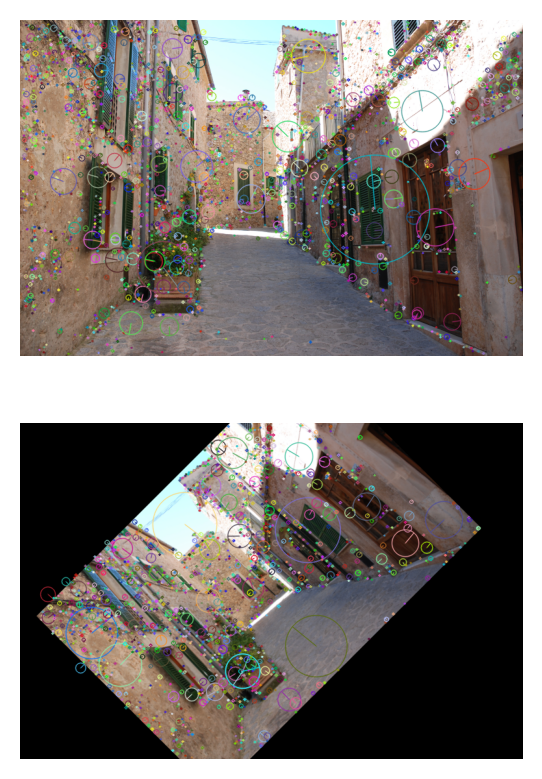

In [2]:
# chuẩn bị ảnh
img = cv.imread("../images/alley.jpg")
H,W = img.shape[:2]

img_trans = cv.resize(img, (W*3//4, H*3//4))
M_rotate = cv.getRotationMatrix2D( (img_trans.shape[1] / 2.0, img_trans.shape[0] / 2.0), 45, 1 ) 
M_shift = np.float32([[1, 0, 30], 
                      [0, 1, 80]])
img_trans = cv.warpAffine(img_trans, M_shift, (W,H))
img_trans = cv.warpAffine(img_trans, M_rotate, (W,H))

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_trans_gray = cv.cvtColor(img_trans, cv.COLOR_BGR2GRAY)


sift = cv.SIFT_create() # khởi tạo lớp thuật toán phát hiện đặc trưng SIFT
kp, des = sift.detectAndCompute(img_gray, None) # xác định các keypoint và descriptor bằng SIFT, trả về danh sách các keypoint
kp_trans, des_trans = sift.detectAndCompute(img_trans_gray, None)

dst = cv.drawKeypoints(img, kp, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
dst_trans = cv.drawKeypoints(img_trans, kp_trans, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.rcParams['figure.dpi']=200
plt.subplot(2, 1, 1)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(cv.cvtColor(dst_trans, cv.COLOR_BGR2RGB))
plt.axis("off")

## SURF

Về ý tưởng, SURF khá tương đồng với SIFT. Điểm khác biệt rõ rệt là SURF tập trung sử dụng các bộ lọc box filter (xấp xỉ LoG, DoG) có tính chất đặc biệt là có thể dễ dàng tính toán bằng mảng cộng dồn, hay việc tính đáp ứng tại pixel $(x,y)$ được thực hiện trong $O(1)$ với việc chuẩn bị trước theo kích thước ảnh. Descriptor trong SURF là tập $(\sum{d_x}, \sum{d_y}, \sum{|d_x|}, \sum{|d_y|})$ tương ứng với tổng các vector gradient (cả về vector và độ lớn) trong vùng thống kê lân cận nhỏ. Tất cả các phép tính gradient, tổng trên đều được tính toàn bằng box filter nên tốc độ xử lý rất nhanh. 

Ưu điểm của SURF là tốc độ xử lý tính toán nhanh hơn nhiều so với SIFT do sử dụng nhiều kỹ thuật cải tiến. Theo OpenCV docs thì tốc độ xử lý của SURF nhanh gấp 3 lần SIFT và kết quả tương đương. Tuy nhiên SURF chỉ được sử dụng hiệu quả với các ảnh bị mờ hoặc xoay và không đạt hiệu quả tốt nếu góc nhìn và cường độ ánh sáng bị thay đổi.

In [3]:
# Có vẻ SURF không available miễn phí với mọi phiên bản OpenCV hiện hành

## FAST

FAST được đề xuất với mục đích xác định các feature góc (corner) có trong ảnh với tốc độ xử lý cao cũng như tài nguyên tính toán hạn chế. Về mặt tổng quan, thuật toán FAST bao gồm các bước như sau:
1. Xác định tham số ngưỡng $t$ cho thuật toán
2. Với mỗi pixel $p$ có độ lớn (độ sáng) bằng $I_p$ (ảnh đầu vào là gray-scale), xét 16 pixel nằm trên đường tròn có tâm là $p$. Nếu tồn tại $n$ pixel liên tiếp có độ sáng nhỏ hơn pixel $p$ (độ lớn nhỏ hơn $I_p-t$) hoặc $n$ pixel liên tiếp có độ sáng lớn hơn $p$ (độ lớn lớn hơn $I_p+t$) thì pixel $p$ đó được coi là corner feature của ảnh.

Để tăng tính hiệu quả của phương pháp FAST, người ta có áp dụng thêm các kỹ thuật học máy để đánh giá xem một pixel $p$ có phải là góc giữa trên 16 pixel lân cận. Việc áp dụng học máy giúp tăng tính hiệu quả của FAST cho từng bài toán riêng biệt.

Ngoài ra để tránh việc các corner feature được phát hiện quá gần nhau, áp dụng phương pháp non-maximal suppression. Ở đây, giá trị score $V$ ở pixel $p$ sẽ bằng tổng trị tuyệt đối giữa $I_p$ với độ lớn của 16 pixel lân cận. Các pixel $p$ là góc chỉ được giữ lại nếu giá trị $V$ là cực đại cục bộ giữa các pixel góc khác xung quanh.

(-0.5, 773.5, 517.5, -0.5)

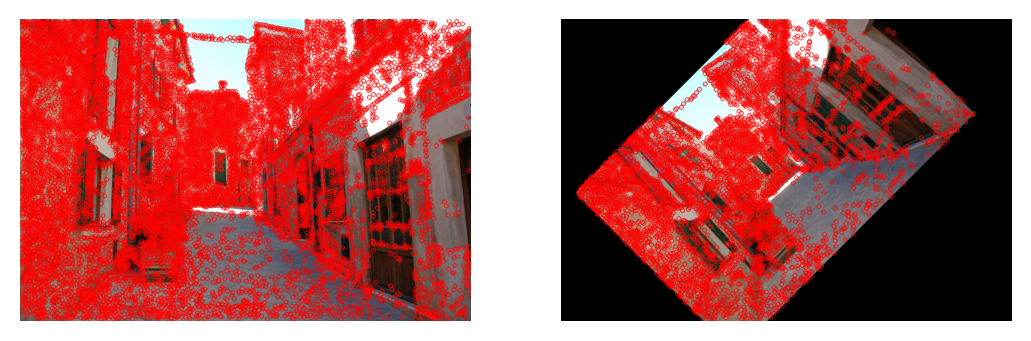

In [4]:
# chuẩn bị ảnh
img = cv.imread("../images/alley.jpg")
H,W = img.shape[:2]

img_trans = cv.resize(img, (W*3//4, H*3//4))
M_rotate = cv.getRotationMatrix2D( (img_trans.shape[1] / 2.0, img_trans.shape[0] / 2.0), 45, 1 ) 
M_shift = np.float32([[1, 0, 30], 
                      [0, 1, 80]])
img_trans = cv.warpAffine(img_trans, M_shift, (W,H))
img_trans = cv.warpAffine(img_trans, M_rotate, (W,H))

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_trans_gray = cv.cvtColor(img_trans, cv.COLOR_BGR2GRAY)


fast = cv.FastFeatureDetector_create() # khởi tạo lớp thuật toán phát hiện đặc trưng FAST với các tham số mặc định
kp = fast.detect(img_gray, None) # xác định các keypoint corner bằng FAST
kp_trans = fast.detect(img_trans_gray, None)

dst = cv.drawKeypoints(img, kp, None, (0,0,255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
dst_trans = cv.drawKeypoints(img_trans, kp_trans, None, (0,0,255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.rcParams['figure.dpi']=200
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(dst_trans, cv.COLOR_BGR2RGB))
plt.axis("off")

## BRIEF

BRIEF là một thuật toán mô tả keypoint với kích thước của cấu trúc mô tả được tính bằng bit. Để hình dùng thì SIFT mô tả keypoint bằng vector 128 chiều, mỗi chiều là một giá trị số thực `float` 4 byte, tức là mô tả của SIFT có kích thước 512 byte. Đối với BRIEF thì một mô tả keypoint sẽ là một vector $n_d$ chiều, mỗi chiều là một giá trị nhị phân 0/1, tức là mô tả BRIEF có kích thước là $n_d$ bit. Thông thường, $n_d$ có giá trị bằng 128, 256, 512. Việc ghép cặp (matching) keypoint có thể được thực hiện bằng công thức tính khoảng cách Hamming.

Ban đầu, thuật toán BRIEF xác định một tập $n_d$ cặp điểm mẫu $\left\{ (\mathbf{x}_i, \mathbf{y}_i) \right\}_{i=1}^{n_d}$ nằm trong một patch hình vuông kích thước $S \times S$ với mục đích dùng để kiểm thử. Tập điểm lấy mẫu sẽ được lấy dựa trên phân phối xác định. Phương pháp lấy mẫu cho ra kết quả ổn định theo như thực nghiệm trong bài báo nghiên cứu là theo phân phối Gauss, $\mathbf{x}_i, \mathbf{y}_i \sim \mathcal{N}(0, \frac{1}{25}S^2) $

Tại mỗi keypoint $\mathbf{p}=(x,y)$, xác định giá trị bit thứ $i$ trong mô tả BRIEF:
* Nếu $I\left(\mathbf{p}+\mathbf{x}_i\right) > I\left(\mathbf{p}+\mathbf{y}_i\right)$, thì bit thứ $i$ bằng $1$.
* Ngược lại, thì bit thứ $i$ bằng $0$.

Tính chất: bất biến với phép dịch nhưng không đối với phép xoay, scale. 

## ORB

ORB là sự kết hợp của phương pháp phát hiện feature ảnh FAST với phương pháp mô tả feature BRIEF để đạt được tốc độ nhanh, yêu cầu ít tài nguyên tính toán. Để đạt được độ hiệu quả tốt tương đương với SIFT, ORB cải tiến bằng cách xác định hướng chính của keypoint tại bước xác định keypoint (bằng FAST), và dựa vào hướng chính đó để mô tả BRIEF có tính chất bất biến với phép xoay. Để có tính chất bất biến với phép scale, ORB thực hiện xác định các điểm keypoint của ảnh trên nhiều độ phân giải khác nhau dựa trên phương pháp phân tầng pyramid. 

Để xác định hướng chính, ORB tính toán điểm trung tâm (centroid) dựa trên moment của patch ảnh. Ở đây, patch ảnh có dạng là hình tròn, với bán kính $r$ bằng với tham số sử dụng ở thuật toán FAST. Khi đó hướng chính của keypoint chính là vector nối giữa keypoint với centroid của patch ảnh.

Khi xác định vector mô tả keypoint bằng BRIEF, tập các cặp điểm mẫu $\left\{ (\mathbf{x}_i, \mathbf{y}_i) \right\}_{i=1}^{n_d}$ sẽ được xoay đi theo hướng chính của keypoint. Nhằm tránh các phép toán phức tạp, thuật toán rời rạc hóa giá trị góc (360 độ) ra thành các giá trị góc cách nhau một khoảng 12 độ để chuẩn bị trước tập các điểm mẫu với góc xoay rời rạc tương ứng. Khi đó thay vì thực hiện phép xoay theo hướng chính thì thuật toán xác định góc xoay rời rạc gần nhất với góc của hướng chính và thực hiện việc lookup cặp điểm mẫu tương ứng.

Việc sử dụng ORB trong OpenCV đơn giản tương tự với SIFT

(-0.5, 773.5, 517.5, -0.5)

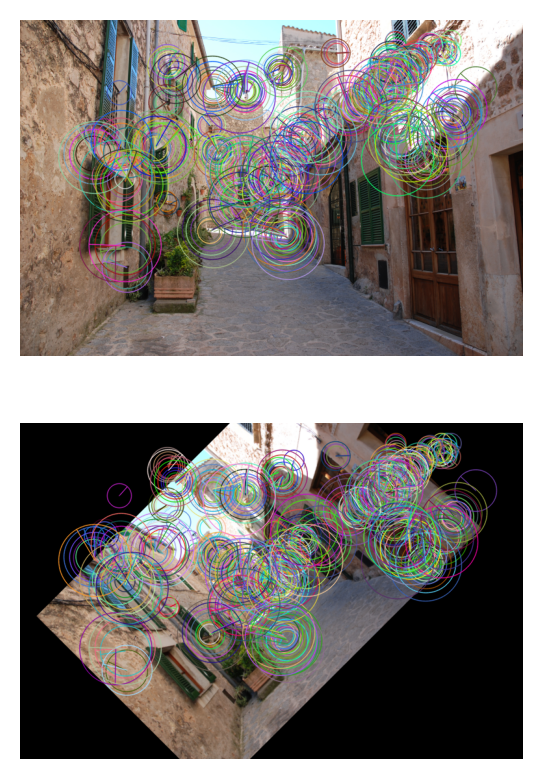

In [5]:
# chuẩn bị ảnh
img = cv.imread("../images/alley.jpg")
H,W = img.shape[:2]

img_trans = cv.resize(img, (W*3//4, H*3//4))
M_rotate = cv.getRotationMatrix2D( (img_trans.shape[1] / 2.0, img_trans.shape[0] / 2.0), 45, 1 ) 
M_shift = np.float32([[1, 0, 30], 
                      [0, 1, 80]])
img_trans = cv.warpAffine(img_trans, M_shift, (W,H))
img_trans = cv.warpAffine(img_trans, M_rotate, (W,H))

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_trans_gray = cv.cvtColor(img_trans, cv.COLOR_BGR2GRAY)


orb = cv.ORB_create() # khởi tạo lớp thuật toán phát hiện đặc trưng ORB
kp = orb.detect(img_gray, None) # xác định các keypoint bằng ORB, trả về danh sách các keypoint
kp, des = orb.compute(img, kp) # xác định description cho các keypoint

kp_trans = orb.detect(img_trans_gray, None) # xác định các keypoint bằng ORB, trả về danh sách các keypoint
kp_trans, des_trans = orb.compute(img_trans, kp) # xác định description cho các keypoint

dst = cv.drawKeypoints(img, kp, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
dst_trans = cv.drawKeypoints(img_trans, kp_trans, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.rcParams['figure.dpi']=200
plt.subplot(2, 1, 1)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(cv.cvtColor(dst_trans, cv.COLOR_BGR2RGB))
plt.axis("off")